In [1]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
import torchvision.utils as vutils
import matplotlib.animation as animation
import matplotlib.pyplot as plt
from IPython.display import HTML



In [2]:
#dataset preparation
transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize(mean=(0.5,), std=(0.5,))
            ])
mnist = datasets.MNIST(root='data', download=True, transform=transform)
#batch_size
batch_size=64
dataloader = DataLoader(mnist, batch_size=batch_size, shuffle=True, drop_last=True)

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [3]:
MODEL_NAME = 'MNIST_GAN'
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("MODEL_NAME = {}, DEVICE = {}".format(MODEL_NAME, DEVICE))

MODEL_NAME = MNIST_GAN, DEVICE = cuda


Model Definition

In [4]:
class Generator(nn.Module):
  def __init__(self):
    super(Generator, self).__init__()
    self.make_mnist = nn.Sequential(
        nn.Linear(100, 256),
        nn.LeakyReLU(0.2, inplace=False),
        nn.Linear(256, 512),
        nn.LeakyReLU(0.2, inplace=False),
        nn.Linear(512, 1024),
        nn.Linear(1024, 28*28),
        nn.Tanh()
    )
  def forward(self, inputs):
    return self.make_mnist(inputs).view(-1,1,28,28)

In [5]:
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()
    self.division = nn.Sequential(
        nn.Linear(28*28,1024),
        nn.LeakyReLU(0.2, inplace=False),
        nn.Dropout(inplace=True),
        nn.Linear(1024,512),
        nn.LeakyReLU(0.2, inplace=False),
        nn.Dropout(inplace=True),
        nn.Linear(512,256),
        nn.LeakyReLU(0.2, inplace=False),
        nn.Dropout(inplace=True),
        nn.Linear(256,1),
        nn.Sigmoid()
    )
  def forward(self, inputs):
    inputs = inputs.view(-1,28*28)
    return self.division(inputs)

In [6]:
G=Generator().to(DEVICE)
D=Discriminator().to(DEVICE)

In [7]:
# utility function to measure time
import time
import math

def timeSince(since):
  now = time.time()
  s = now - since
  m = math.floor(s/60)
  s -= m*60
  return '%dm %ds'%(m,s)

In [8]:
criterion = nn.BCELoss()
G_optim = Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))
D_optim = Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [9]:
D_losses = []
G_losses = []
img_list = [] 
# Create batch of latent vectors that we will use to visualize
fixed_noise = torch.randn(batch_size, 100).to(DEVICE)

In [10]:
max_epoch = 5
step = 0 
plot_every = 200

total_D_loss = 0
total_G_loss = 0

start = time.time()

for epoch in range(max_epoch):
  for i,(real_data, _) in enumerate(dataloader, 0):
    target_real = torch.ones(batch_size, 1)
    target_fake = torch.zeros(batch_size, 1)
    x, y_real, y_fake = real_data.to(DEVICE), target_real.to(DEVICE), target_fake.to(DEVICE)
    
    ###I. Discriminator training###
    D_result_from_real = D(x) # real image
    D_loss_real = criterion(D_result_from_real, y_real) 

    z=torch.randn((batch_size, 100))
    x_fake = z.to(DEVICE)

    fake_data = G(x_fake) #make fake image
    D_result_from_fake = D(fake_data) 
    D_loss_fake = criterion(D_result_from_fake,y_fake)
    D_loss = D_loss_real + D_loss_fake # sum of losses

    D.zero_grad()
    D_loss.backward()
    D_optim.step()
    

    ###II. Generator training###
    z=torch.randn((batch_size, 100))
    x_fake=z.to(DEVICE)

    fake_data = G(x_fake) #make fake image
    D_result_from_fake=D(fake_data)
    G_loss = criterion(D_result_from_fake, y_real)

    G.zero_grad()
    G_loss.backward()
    G_optim.step()

    # Save Losses for plotting later
    D_losses.append(D_loss.item())
    G_losses.append(G_loss.item())

    # Output training stats
    if step % 500 == 0 :
      print('Epoch ({}): {}/{}, Step: {}, G_Loss: {}, D_Loss: {}'.format(timeSince(start), epoch, max_epoch, step, G_loss.item(), D_loss.item()))

    # Check how the generator is doing by saving G`s output on fixed_noise 
    if (step % 500 == 0) or ((epoch == max_epoch-1) and (i == len(dataloader)-1)):
      with torch.no_grad():
        fake = G(fixed_noise).detach().cpu()
        #fake = fake.view(batch_size, 28, 28).cpu()
        img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

    step+=1

Epoch (0m 0s): 0/5, Step: 0, G_Loss: 0.6616442203521729, D_Loss: 1.3812832832336426
Epoch (0m 10s): 0/5, Step: 500, G_Loss: 1.8113281726837158, D_Loss: 0.9846179485321045
Epoch (0m 19s): 1/5, Step: 1000, G_Loss: 1.599413514137268, D_Loss: 0.9373921155929565
Epoch (0m 29s): 1/5, Step: 1500, G_Loss: 2.1402626037597656, D_Loss: 0.6723090410232544
Epoch (0m 39s): 2/5, Step: 2000, G_Loss: 3.3667984008789062, D_Loss: 0.6471071839332581
Epoch (0m 49s): 2/5, Step: 2500, G_Loss: 1.9663618803024292, D_Loss: 0.6799839735031128
Epoch (0m 58s): 3/5, Step: 3000, G_Loss: 1.6554114818572998, D_Loss: 0.7297880053520203
Epoch (1m 8s): 3/5, Step: 3500, G_Loss: 1.4520198106765747, D_Loss: 0.6269738674163818
Epoch (1m 18s): 4/5, Step: 4000, G_Loss: 1.7247097492218018, D_Loss: 0.7792361974716187
Epoch (1m 28s): 4/5, Step: 4500, G_Loss: 1.9004676342010498, D_Loss: 0.7123976945877075


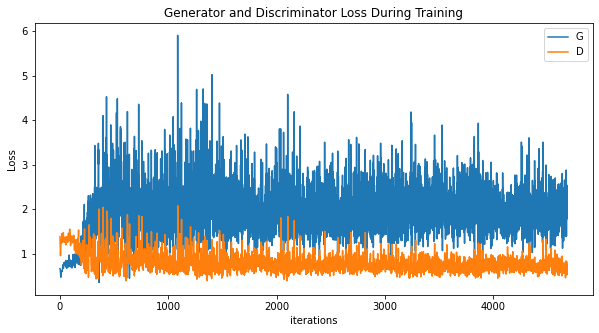

In [11]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

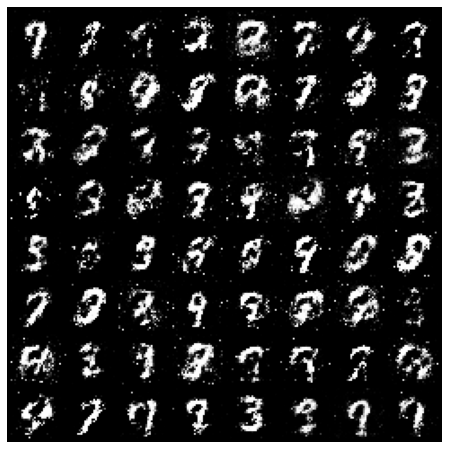

In [12]:
#visualization how the generator is doing by saving G`s output on fixed_noise
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True, cmap='gray')] for i in img_list] # if the images 3 channel -> np.transpose(i,(1,2,0))
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)
HTML(ani.to_jshtml())